In [31]:
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Resize, Normalize, Compose
from torchvision.transforms import v2
import torch
from torch import nn
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from sklearn import metrics
import os
import time

VALIDATION = 0.2
FASHION_BATCH_SIZE = 200
matrix_transforms = v2.Compose([
    ToTensor(),
    Resize((64, 64)),
    Normalize(0.5, 0.5),
])


class EarlyStopping():
    def __init__(self, path : str, patience=5, threshold=1e-4):
        self.patience = patience
        self.threshold = threshold
        self.min_loss = 10000
        self.steps_till_stop = 0
        self.path = path

    def continue_training(self, model, loss):
        if(loss < self.min_loss - self.threshold):
            self.min_loss = loss
            self.steps_till_stop = 0
            torch.save(model.state_dict(), self.path)
            return True
        if (loss >= self.min_loss - self.threshold):
            self.steps_till_stop += 1
            if (self.steps_till_stop == self.patience): return False
        return True
    
    def load_model(self, model):
        model.load_state_dict(torch.load(self.path, weights_only=True))
        return model



def plot_losses(train_losses: list[float], validation_losses: list[float], label_x : str, label_y : str) -> None:
    """Plots training and validation losses over epochs."""
    plt.figure(figsize=(8, 6))
    plt.plot(train_losses, label=label_x, marker="o")
    plt.plot(validation_losses, label=label_y, marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

def get_fashion_dataloader(size : int):
    train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=matrix_transforms)
    test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=matrix_transforms)
    train_dataloader = DataLoader(train_data, batch_size=size, shuffle=False)
    test_dataloader = DataLoader(test_data, batch_size=size, shuffle=False)
    return train_data, test_data, train_dataloader, test_dataloader

train_fashion_dataset, test_fashion_dataset, train_fashion_dataloader, test_fashion_dataloader = get_fashion_dataloader(FASHION_BATCH_SIZE)
FASHION_KEYS = np.unique(train_fashion_dataset.targets)

In [37]:
class InfoLoaderDataset(Dataset):
    def __init__(self, data, labels, num_classes, transforms = None):
        self.data = data
        self.labels = labels
        self.num_classes = num_classes
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if (self.transforms == None):
            return self.data[idx], self.labels[idx]
        data = self.data[idx].detach().numpy()
        return self.transforms(data), self.labels[idx]

def initialiseTrainingModelHelpers(model, parameters):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=parameters['lr_optimizer'], weight_decay=parameters['weight_decay_factor'])
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                    factor=parameters['gamma_lr'], patience=parameters['patience'], verbose=True)
    return criterion, optimizer, lr_scheduler

def train(model, dataloader, optimizer, criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.train()
    model.to(device)
    train_loss = 0
    all_preds = []
    all_labels= []
    for idx, (inputs, labels) in enumerate(dataloader):
        inputs = inputs.type(torch.float32)
        labels = labels.type(torch.LongTensor)
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        all_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    return train_loss / len(dataloader), accuracy_score(all_preds, all_labels)

def test(model, dataloader, criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    with torch.no_grad():
        validation_loss = 0
        all_preds = []
        all_labels= []
        for inputs, labels in dataloader:
            inputs = inputs.type(torch.float32)
            labels = labels.type(torch.LongTensor)
            inputs, labels = inputs.to(device), labels.to(device)
            out = model(inputs)
            validation_loss += criterion(out, labels).item()
            all_preds.extend(torch.argmax(out, dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
        return validation_loss / len(dataloader), accuracy_score(all_preds, all_labels), all_preds, all_labels

def train_model(model, data, criterion, optimizer, lr_scheduler, epochs, early_stopper : EarlyStopping):
    train_info = {
        "train_loss": [],
        "validation_loss" : [],
        "train_accuracy": [],
        "validation_accuracy" : []
    }
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    max_acc = 0
    for i in range(epochs):
        train_loss, train_acc = train(model, data["train"], optimizer, criterion)
        val_loss, val_acc, _, _ = test(model, data["validation"], criterion)
        time.sleep(2)
        if (val_acc > max_acc):
            max_acc = val_acc
            print("acuratete maxima la epoca", i)
        lr_scheduler.step(val_loss)
        print(val_loss, val_acc, "epoch: ", i)
        train_info["train_loss"].append(train_loss)
        train_info["validation_loss"].append(val_loss)
        train_info["train_accuracy"].append(train_acc)
        train_info["validation_accuracy"].append(val_acc)
        if not early_stopper.continue_training(model, val_loss): break
    return train_info

def test_model(model, dataloader, criterion):
    loss, accuracy, pred, labels = test(model, dataloader, criterion)
    print("loss was:", loss, " accuracy was:", accuracy)
    confusion_matrix = metrics.confusion_matrix(labels, pred)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    cm_display.plot()
    plt.show()


def execute_pipeline(model, data, parameters, early_stopper):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion, optimizer, lr_scheduler = initialiseTrainingModelHelpers(model, parameters)
    train_info = train_model(model, data, criterion, optimizer,
                             lr_scheduler, parameters['epochs'], early_stopper)
    plot_losses(train_info["train_loss"], train_info["validation_loss"], "Train Loss", "Validation Loss")
    plot_losses(train_info["train_accuracy"], train_info["validation_accuracy"], "Train Accuracy", "Validation Accuracy")
    model = early_stopper.load_model(model)
    test_model(model, data["test"], criterion)


In [ ]:
# Task 1
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

from task1_aux import compute_vocabulary, create_initial_features, compute_attributes
pd.set_option("display.precision", 15)
SIZE = (28, 28)
BATCH_SIZE = 100
# DE ADAUGAT TRANSFORMARI
vocabulary = compute_vocabulary(train_fashion_dataloader, 5)
print(vocabulary.shape)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
X_train, y_train = create_initial_features(train_fashion_dataloader, vocabulary, FASHION_BATCH_SIZE)
X_test, y_test = create_initial_features(test_fashion_dataloader, vocabulary, FASHION_BATCH_SIZE)
rf.fit(X_train, y_train)
accuracy_before = rf.score(X_test, y_test)
print(f'accuracy after one more step', accuracy_before)
importances = rf.feature_importances_
feature_names = range(vocabulary.shape[0])
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
top_features = feature_importance_df['Feature'][:64].values
vocabulary = vocabulary[top_features]
X_train, y_train, X_validation, y_validation, X_test, y_test = compute_attributes(vocabulary,
                            train_fashion_dataloader,  test_fashion_dataloader, FASHION_BATCH_SIZE, FASHION_KEYS, VALIDATION)
data = {
    "train":  DataLoader(InfoLoaderDataset(X_train, y_train, 10), BATCH_SIZE, shuffle=True),
    "validation": DataLoader(InfoLoaderDataset(X_validation, y_validation, 10), BATCH_SIZE, shuffle=True),
    "test": DataLoader(InfoLoaderDataset(X_test, y_test, 10), BATCH_SIZE, shuffle=True),
}
print(vocabulary.shape)

a ajuns la epoca: 0
a ajuns la epoca: 100
a ajuns la epoca: 200
(1500, 36)
accuracy after one more step 0.6591
(60000, 64) (60000,)
(10000, 64) (10000,)
(64, 36)


In [38]:
SIZE = (28, 28)
EXPANSION = 4
EPOCHS = 3
LR_OPTIMIZER = 1e-4
GAMMA_LR = 0.7
WEIGHT_DECAY_FACTOR = 1e-4
PATIENCE = 3
EARLY_STOPPING_PATIENCE = 6


class FeaturesMLP(nn.Module):
    def __init__(self, initial_features, num_classes=10):
        super(FeaturesMLP, self).__init__()
        width1 = initial_features
        width2  = width1 * EXPANSION
        self.fc1 = nn.Linear(width1, width2)
        self.bn1 = nn.BatchNorm1d(width2)

        width3 = width2 * EXPANSION
        self.fc2 = nn.Linear(width2, width3)
        self.bn2 = nn.BatchNorm1d(width3)

        self.fc3 = nn.Linear(width3, width2)
        self.bn3 = nn.BatchNorm1d(width2)

        self.fc4 = nn.Linear(width2, width1)
        self.bn4 = nn.BatchNorm1d(width1)

        self.fc5 = nn.Linear(width1, num_classes)
        self.relu = nn.ReLU(inplace=True)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x: torch.Tensor):
        x = self.bn1(self.relu(self.fc1(x)))
        x = self.bn2(self.relu(self.fc2(x)))
        x = self.bn3(self.relu(self.fc3(x)))
        x = self.bn4(self.relu(self.fc4(x)))
        return self.softmax(self.fc5(x))

model = FeaturesMLP(64)
parameters = {
    'batch_size': BATCH_SIZE,
    'epochs' : EPOCHS,
    'lr_optimizer': LR_OPTIMIZER,
    'gamma_lr': GAMMA_LR,
    'weight_decay_factor': WEIGHT_DECAY_FACTOR,
    'patience': PATIENCE,
}

execute_pipeline(model, data, parameters)

TypeError: execute_pipeline() missing 1 required positional argument: 'early_stopper'

In [42]:
# Task 2
from task1_aux import split_data_in_training_validation
SIZE = (28, 28)
BATCH_SIZE = 100
EXPANSION = 4
EPOCHS = 40
LR_OPTIMIZER = 1e-4
GAMMA_LR = 0.5
WEIGHT_DECAY_FACTOR = 1e-4
PATIENCE = 3

class FullImageMLP(nn.Module):
    def __init__(self, num_classes=10):
        super(FullImageMLP, self).__init__()
        self.fc1 = nn.Linear(784, 250)
        self.bn1 = nn.BatchNorm1d(250)
        self.fc2 = nn.Linear(250, 250)
        self.bn2 = nn.BatchNorm1d(250)
        self.fc3 = nn.Linear(250, num_classes)
        self.relu = nn.ReLU(inplace=True)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x: torch.Tensor):
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.bn1(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.bn2(x)
        return self.softmax(self.fc3(x))

transforms = v2.Compose([
    ToTensor(),
    Resize(SIZE),
    Normalize(0.5, 0.5),
])

X_train, y_train, X_validation, y_validation = split_data_in_training_validation(train_fashion_dataset.data,
                                                    train_fashion_dataset.targets, FASHION_KEYS, VALIDATION)
X_test, y_test = test_fashion_dataset.data, test_fashion_dataset.targets
data = {
    "train" : DataLoader(InfoLoaderDataset(X_train, y_train, 10, transforms), BATCH_SIZE, shuffle=True),
    "validation": DataLoader(InfoLoaderDataset(X_validation, y_validation, 10, transforms), BATCH_SIZE, shuffle=True),
    "test": DataLoader(InfoLoaderDataset(X_test, y_test, 10, transforms), BATCH_SIZE, shuffle=True)
}

acuratete maxima la epoca 0
1.6361648221810658 0.8444166666666667 epoch:  0
acuratete maxima la epoca 1
1.6185736119747163 0.853 epoch:  1
acuratete maxima la epoca 2
1.6141901463270187 0.8554166666666667 epoch:  2
acuratete maxima la epoca 3
1.5998390982548396 0.8681666666666666 epoch:  3
acuratete maxima la epoca 4
1.5955533176660537 0.8718333333333333 epoch:  4
acuratete maxima la epoca 5
1.5922530273596445 0.8750833333333333 epoch:  5
1.5933025449514389 0.8725 epoch:  6
acuratete maxima la epoca 7
1.5873307357231776 0.8780833333333333 epoch:  7
1.5904602468013764 0.875 epoch:  8
1.58932952384154 0.8755 epoch:  9
acuratete maxima la epoca 10
1.5867990324894587 0.8781666666666667 epoch:  10
acuratete maxima la epoca 11
1.5813731342554092 0.8844166666666666 epoch:  11
1.5846684962511062 0.87975 epoch:  12
acuratete maxima la epoca 13
1.5790341605742773 0.8849166666666667 epoch:  13
1.5834617386261622 0.8799166666666667 epoch:  14
acuratete maxima la epoca 15
1.5767435451348624 0.88875

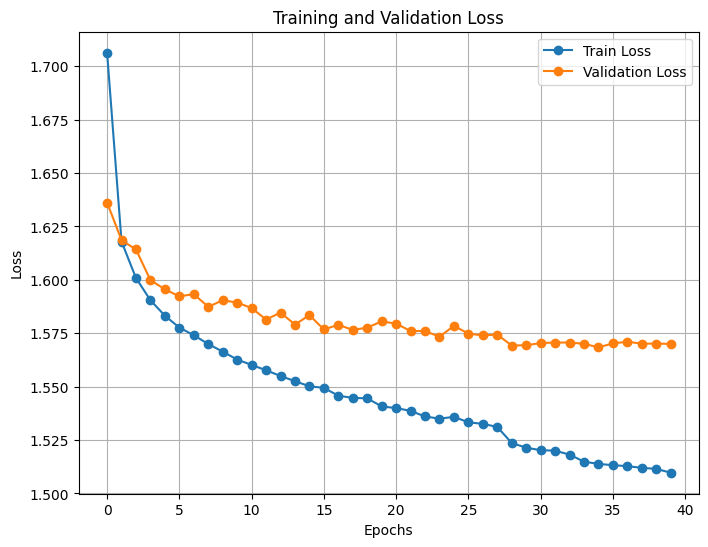

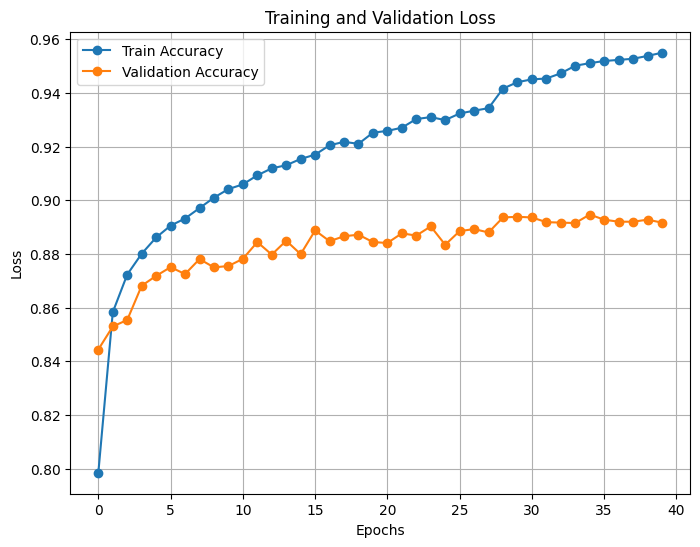

loss was: 1.5745214605331421  accuracy was: 0.888


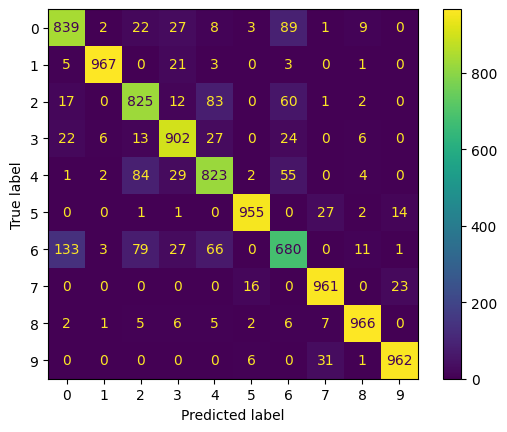

In [43]:
model = FullImageMLP()
parameters = {
    'batch_size': BATCH_SIZE,
    'epochs' : EPOCHS,
    'lr_optimizer': LR_OPTIMIZER,
    'gamma_lr': GAMMA_LR,
    'weight_decay_factor': WEIGHT_DECAY_FACTOR,
    'patience': PATIENCE,
}
early_stopper =  EarlyStopping("./task2.pth", EARLY_STOPPING_PATIENCE)
execute_pipeline(model, data, parameters, early_stopper)

In [4]:
# Task 3
from task1_aux import split_data_in_training_validation
SIZE = (28, 28)
BATCH_SIZE = 100
EPOCHS = 40
LR_OPTIMIZER = 1e-4
GAMMA_LR = 0.5
WEIGHT_DECAY_FACTOR = 1e-4
PATIENCE = 3
VALIDATION = 0.2
BASE_DEPTH = 16
EXPANSION = 4
NR_LAYERS_BLOCK = 2
EARLY_STOPPING_PATIENCE = 7

training_transforms = v2.Compose([
    ToTensor(),
    v2.RandomHorizontalFlip(),
    v2.RandomRotation(degrees=90),
    v2.RandomCrop(
      size=(SIZE),
      padding=(4, 4),
      padding_mode="reflect"),
    Resize(SIZE),
    Normalize(0.5, 0.5)
])

testing_transforms = v2.Compose([
    ToTensor(),
    Resize(SIZE),
    Normalize(0.5, 0.5)
])

X_train, y_train, X_validation, y_validation = split_data_in_training_validation(train_fashion_dataset.data,
                                                    train_fashion_dataset.targets, FASHION_KEYS, VALIDATION)
X_test, y_test = test_fashion_dataset.data, test_fashion_dataset.targets
data = {
    "train": DataLoader(InfoLoaderDataset(X_train, y_train, 10, training_transforms), BATCH_SIZE, shuffle=True),
    "validation": DataLoader(InfoLoaderDataset(X_validation, y_validation, 10, testing_transforms), BATCH_SIZE, shuffle=True),
    "test":  DataLoader(InfoLoaderDataset(X_test, y_test, 10, testing_transforms), BATCH_SIZE, shuffle=True),
}

data_no_transform = {
    "train": DataLoader(InfoLoaderDataset(X_train, y_train, 10), BATCH_SIZE, shuffle=True),
    "validation": DataLoader(InfoLoaderDataset(X_validation, y_validation, 10), BATCH_SIZE, shuffle=True),
    "test":  DataLoader(InfoLoaderDataset(X_test, y_test, 10), BATCH_SIZE, shuffle=True),
}

In [5]:
def conv3x3(in_planes, out_planes, stride=1, padding=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=padding, bias=False)

def conv1x1(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class ConvBlock(nn.Module):
    def __init__(self, bottleneck_channels, block_channels, norm_layer):
        super(ConvBlock, self).__init__()
        self.conv1 = conv1x1(block_channels, bottleneck_channels)
        self.norm1 = norm_layer(bottleneck_channels)
        self.conv2 = conv3x3(bottleneck_channels, bottleneck_channels)
        self.norm2 = norm_layer(bottleneck_channels)
        self.conv3 = conv1x1(bottleneck_channels, block_channels)
        self.norm3 = norm_layer(block_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.norm1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.norm2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.norm3(out)
        out += identity
        out = self.relu(out)
        return out

class DeepConvNet(nn.Module):
    def __init__(self, base_depth=BASE_DEPTH, expansion=EXPANSION, nr_layer_blocks=NR_LAYERS_BLOCK, num_classes=10):
        super(DeepConvNet, self).__init__()
        self.base_depth = base_depth
        # convert image to grayscale before applying transformation
        self.conv1 = nn.Conv2d(1, self.base_depth, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.relu = nn.ReLU(inplace=True)
        depth1 = self.base_depth * expansion
        self.conv_depth1 = conv1x1(self.base_depth, depth1, stride=1)
        self.norm_depth1 = nn.BatchNorm2d(depth1)
        # # #### Layer 1, 3 blocks
        self.layer1 = nn.Sequential(
            *[ConvBlock(self.base_depth, depth1, nn.BatchNorm2d)] * nr_layer_blocks
        )

        # # change to 128 channels base and image size 8x8
        depth2 = depth1 * expansion
        self.conv_depth2 = conv1x1(depth1, depth2, 2)
        self.norm_depth2 = nn.BatchNorm2d(depth2)

        # #### Layer 2, 3 blocks
        self.layer2 = nn.Sequential(
            *[ConvBlock(depth1, depth2, nn.BatchNorm2d)] * nr_layer_blocks
        )

        # change to 256 chanels and image size 4x4
        depth3 = depth2 * expansion
        self.conv_depth3 = conv1x1(depth2, depth3, 2)
        self.norm_depth3 = nn.BatchNorm2d(depth3)

        # Layer 3, 3 blocks
        self.layer3 = nn.Sequential(
            *[ConvBlock(depth2, depth3, nn.BatchNorm2d)] * nr_layer_blocks
        )

        depth4 = depth3 * expansion
        self.conv_depth4 = conv1x1(depth3, depth4, 2)
        self.norm_depth4 = nn.BatchNorm2d(depth4)
        self.layer4 = nn.Sequential(
            *[ConvBlock(depth3, depth4, nn.BatchNorm2d)] * nr_layer_blocks
        )

        # # AveragePooling
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classification_layer = nn.Sequential(*[
            nn.Linear(depth4, depth3),
            nn.Dropout(0.3),
            nn.Linear(depth3, depth2),
            nn.Dropout(0.3),
            nn.Linear(depth2, num_classes)
        ])


    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.conv_depth1(x)
        x = self.norm_depth1(x)
        x = self.layer1(x)

        x = self.relu(self.conv_depth2(x))
        x = self.norm_depth2(x)
        x = self.layer2(x)

        x = self.relu(self.conv_depth3(x))
        x = self.norm_depth3(x)
        x = self.layer3(x)

        x = self.relu(self.conv_depth4(x))
        x = self.norm_depth4(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        # de la clasification layer
        return self.classification_layer(x)

In [ ]:
model = DeepConvNet()
parameters = {
    'batch_size': BATCH_SIZE,
    'epochs' : EPOCHS,
    'lr_optimizer': LR_OPTIMIZER,
    'gamma_lr': GAMMA_LR,
    'weight_decay_factor': WEIGHT_DECAY_FACTOR,
    'patience': PATIENCE,
    'validation': VALIDATION,
    'base_depth': BASE_DEPTH,
    'expansion': EXPANSION,
    'nr_layers_block': NR_LAYERS_BLOCK,
}

early_stopper =  EarlyStopping("./task3_transforms.pth", EARLY_STOPPING_PATIENCE)
execute_pipeline(model, data, parameters, early_stopper)


In [ ]:
model = DeepConvNet()
parameters = {
    'batch_size': BATCH_SIZE,
    'epochs' : EPOCHS,
    'lr_optimizer': LR_OPTIMIZER,
    'gamma_lr': GAMMA_LR,
    'weight_decay_factor': WEIGHT_DECAY_FACTOR,
    'patience': PATIENCE,
    'validation': VALIDATION,
    'base_depth': BASE_DEPTH,
    'expansion': EXPANSION,
    'nr_layers_block': NR_LAYERS_BLOCK,
}

early_stopper =  EarlyStopping("./task3_simple.pth", EARLY_STOPPING_PATIENCE)
execute_pipeline(model, data_no_transform, parameters)

In [8]:
# Task 4
from torchvision import models
model = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model.fc.in_features
print(num_ftrs)
print(model.fc.out_features)
model.fc = nn.Linear(num_ftrs, 10)

512
1000
